# Uber Demand and Supply Gap Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Read the given Uber Request Data. csv into a data frame uber_df
# It is expected that the file with data is kept in the same folder
# as this ipynb file.
uber_df = pd.read_csv("Uber Request Data.csv",encoding="ISO-8859-1")
print(uber_df.shape)
print(uber_df.info())


(6745, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 6 columns):
Request id           6745 non-null int64
Pickup point         6745 non-null object
Driver id            4095 non-null float64
Status               6745 non-null object
Request timestamp    6745 non-null object
Drop timestamp       2831 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 316.2+ KB
None


In [3]:
# Inspecting thedata
uber_df.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47


###### Data cleaning####


In [4]:
# 1 :- Fix Rows : - 
#  Delete Incorrect values 
#  Delete Summary Rows
#  Delete Extra Rows
# Ans -> We donot have any headers, footers, summarizing rows, totalling rows.

# 2 :- Standardising Values :- 
#  Standardise units: Ensure all observations under a variable have a common and 
#   consistent unit, e.g. convert lbs to kgs, miles/hr to km/hr, etc.
#  Scale values if required: Make sure the observations under a variable have a 
#   common scale
#  Standardise precision for better presentation of data, e.g. 4.5312341 kgs to 4.53 kgs.
#  Remove outliers: Remove high and low values that would disproportionately affect
#   the results of your analysis.
#  Fix missing values
# Ans -> The Request and Drop timestamp are part of masked data which contains different
#      formats. Need to standardize it.

# Step 1 : Ensuring the Request and Srop Timestamp string has date separator as '/' 
# uniformly.
uber_df['Request timestamp']= uber_df['Request timestamp'].str.replace('/','-')
uber_df['Drop timestamp']= uber_df['Drop timestamp'].str.replace('/','-')
uber_df.head(30)

# Step 2: Ensuring the Request and Drop timestamp are into the standard Date Time format 
# "dayfirst = true" is used otherwise pythondate time will read 11/7/2016 as 7 Nov
# instead of 11th July.
uber_df['Request timestamp']= pd.to_datetime(uber_df['Request timestamp'],dayfirst=True)
uber_df['Drop timestamp']= pd.to_datetime(uber_df['Drop timestamp'],dayfirst=True)
uber_df.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,2016-07-11 11:51:00,2016-07-11 13:00:00
1,867,Airport,1.0,Trip Completed,2016-07-11 17:57:00,2016-07-11 18:47:00
2,1807,City,1.0,Trip Completed,2016-07-12 09:17:00,2016-07-12 09:58:00
3,2532,Airport,1.0,Trip Completed,2016-07-12 21:08:00,2016-07-12 22:03:00
4,3112,City,1.0,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47


In [5]:
# 3: Fix Missing Values 
#  Set values as missing values: Identify values that indicate missing data, and yet are 
#   not recognised by the software as such, e.g treat blank strings, "NA", "XX", "999" etc. 
#   as missing.
#  Adding is good, exaggerating is bad: You should try to get information from reliable
#   external sources as much as possible, but if you can’t, then it is better to keep 
#   missing values as such rather than exaggerating the existing rows/columns.
#  Delete rows, columns: Rows could be deleted if the number of missing values are 
#   insignificant in number, as this would not impact the analysis. Columns could be 
#   removed if the missing values are quite significant in number.
#  Fill partial missing values using business judgement: Missing time zone, century, etc. 
#   These values are easily identifiable.

# Ans:-> Checking for row wise nulls 
# The isnull() function finds the rows ( axis =0 ) as null for columns and sum() 
# function sums up row values for each column 
print(uber_df.isnull().sum(axis=0))

# We see that in uber_df dataframe we have 2650 rows null for Driver Id and 3914 null for
# Drop Timestamp. We need to check if this is expected data or there is some unknown 
# missing data.

df_null_driverid_no_cars = uber_df.loc[(uber_df['Driver id'].isnull()) & (uber_df['Status'] =='No Cars Available') ]
print("\nThe count of columns in the data frame containing Driver Id as Null and No Cars Available :-\n")
print(df_null_driverid_no_cars.count() )
# Since the Driver Id is null for 2650 rows in uber_df and is null for 2650 rows in
# the data frame containing DriverId as Null and "No Cars Available", hence we can
# conclude that whenever the Driver Id was null in uber_df, the Car was not available.
# Also, the Drop Timestamp for these 2650 values is also null, which shows that since car
# was not available drop could not happen

df_null_drop_and_cancelled = uber_df.loc[(uber_df['Drop timestamp'].isnull()) & \
                                         (uber_df['Status'] =='Cancelled') ]
print('\nThe count of columns in the data frame containing Drop timestamp as Null and'\
        'Cancelled :-\n')
print(df_null_drop_and_cancelled.count() )

# Since the Drop Timestamp is null for 1264 rows in the data frame containing Drop Timestamp
# as Null and Status as "Cancelled" with Driver Id as not null, we can conclude
# that the Drop timestamp was not available since the Trip was cancelled
# When we add up the rows for Drop timestamp where 
# 1) Driver Id was null and "No Cars Available" and 
# 2) Driver Id was not null and Status of Trip was "Cancelled" we have in all total
# Drop timestamp missing 2650 +1264 = 3914 the total no of null columns in uber_df 
# for Drop timestamp. 
# Hence, we can conclude that we have Drop Timestamp and Driver Ids as null values 
# for only those trips which were either "Cancelled" or "Car was not available". 
# So we donot have  any unknown missing values i.e. data is proper and we dont need 
# to delete any values.


Request id              0
Pickup point            0
Driver id            2650
Status                  0
Request timestamp       0
Drop timestamp       3914
dtype: int64

The count of columns in the data frame containing Driver Id as Null and No Cars Available :-

Request id           2650
Pickup point         2650
Driver id               0
Status               2650
Request timestamp    2650
Drop timestamp          0
dtype: int64

The count of columns in the data frame containing Drop timestamp as Null andCancelled :-

Request id           1264
Pickup point         1264
Driver id            1264
Status               1264
Request timestamp    1264
Drop timestamp          0
dtype: int64


In [6]:
# 4 :- Fix Columns :- 
#  Merge columns for creating unique identifiers if needed: E.g. Merge State, City into 
#   Full address
#  Split columns for more data: Split address to get State and City to analyse each
#   separately
#  Add column names: Add column names if missing
#  Rename columns consistently: Abbreviations, encoded columns
#  Delete columns: Delete unnecessary columns
#  Align misaligned columns: Dataset may have shifted columns
# Ans -> 
# We have only categorical data so far. It would be good to split the Request Time Stamp
# into Request year, Request Hour and Request Day which might help us with analysis in
# future

uber_df['Request Year'] = uber_df['Request timestamp'].dt.year
uber_df['Request Hour'] = uber_df['Request timestamp'].dt.hour
uber_df['Request Day'] = uber_df['Request timestamp'].dt.day
# Inspecting data
uber_df


,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp,Request Year,Request Hour,Request Day
0,619,Airport,1.0,Trip Completed,2016-07-11 11:51:00,2016-07-11 13:00:00,2016,11,11
1,867,Airport,1.0,Trip Completed,2016-07-11 17:57:00,2016-07-11 18:47:00,2016,17,11
2,1807,City,1.0,Trip Completed,2016-07-12 09:17:00,2016-07-12 09:58:00,2016,9,12
3,2532,Airport,1.0,Trip Completed,2016-07-12 21:08:00,2016-07-12 22:03:00,2016,21,12
4,3112,City,1.0,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47,2016,8,13
5,3879,Airport,1.0,Trip Completed,2016-07-13 21:57:28,2016-07-13 22:28:59,2016,21,13
6,4270,Airport,1.0,Trip Completed,2016-07-14 06:15:32,2016-07-14 07:13:15,2016,6,14
7,5510,Airport,1.0,Trip Completed,2016-07-15 05:11:52,2016-07-15 06:07:52,2016,5,15
8,6248,City,1.0,Trip Completed,2016-07-15 17:57:27,2016-07-15 18:50:51,2016,17,15
9,267,City,2.0,Trip Completed,2016-07-11 06:46:00,2016-07-11 07:25:00,2016,6,11


In [7]:
# 5:-  Invalid Values
#  Encode unicode properly: In case the data is being read as junk characters, try to
#   change encoding, E.g.CP1252 instead of UTF-8.
#  Convert incorrect data types: Correct the incorrect data types to the correct data 
#   types for ease of analysi E.g. if numeric values are stored as strings, it would not
#   be possible to calculate metrics such as mean, median, etc. Some of the common data
#   type corrections are — string to number: "12,300" to “12300”; string to date: 
#   "2013-Aug"  to “2013/08”; number to string: “PIN Code 110001” to "110001"; etc.
#  Correct values that go beyond range: If some of the values are beyond logical range,
#   e.g. temperature less than -273° C (0° K), you would need to correct them as required. 
#   A close look would help you check if there is scope for correction, or if the value 
#   needs to be removed.
#  Correct values not in the list: Remove values that don’t belong to a list. E.g. In a
#   data set containing blood groups of individuals, strings “E” or “F” are invalid values 
#   and can be removed.
#  Correct wrong structure: Values that don’t follow a defined structure can be removed. 
#   E.g. In a data set containing pin codes of Indian cities, a pin code of 12 digits
#   would be an invalid value and needs to be removed. Similarly, a phone number of 12
#   digits would be an invalid value.
#  Validate internal rules: If there are internal rules such as a date of a product’s 
#   delivery must definitely be after the date of the order, they should be correct and 
#   consistent.
# Ans -> The data doesnt seem to have invalid values. There are missing values for Drop
# Id and Driver Id which have already been inspected and found as expected   

In [8]:
# 6:- Filtering Data
#  De-duplicate data: Remove identical rows, remove rows where some columns are 
#   identical
#  Filter rows: Filter by segment, filter by date period to get only the rows relevant
#    to the analysis
#  Filter columns: Pick columns relevant to the analysis
#  Aggregate data: Group by required keys, aggregate the rest

# Ans:-
# Checking for duplicate Rows
# Create a table of those culprit rows which are duplicated:
dups = uber_df.groupby(uber_df.columns.tolist()).size().reset_index().\
       rename(columns={0:'count'})

# sum the final col of that table, and subtract the number of culprits:
dups['count'].sum() - dups.shape[0]

# Since the answer is 0, we donot have any dupicate rows to take care of.

# Filtering rows
# It is given that we have been given data for Airport to City and City to Airport
# which is the main culprit so we need not filter rows on that basis 


0

###### Univariate Analysis, Bivariate Analysis and Derived Metrics ####

Request Year
2016    13597920
Name: Request Year, dtype: int64 

Request Day
11    15037
12    15684
13    17381
14    18942
15    20715
Name: Request Day, dtype: int64


/Users/karandeepmalik/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


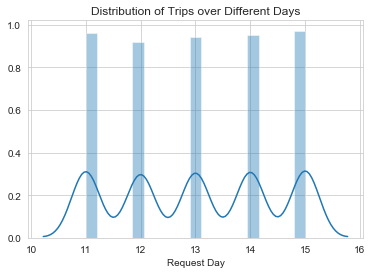

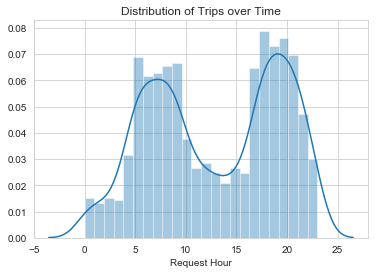

In [9]:
# Univariate Analysis

# Let's try to understand the distribution of data based on hour and day
sns.set_style("whitegrid")

# Let's group by on the basis of Request Year to find that data is given
# for how many years

print(uber_df.groupby(by=['Request Year'])['Request Year'].sum(),'\n')
# The data is only for Year 2016

# Let's group by on the basis of Request Day to find that data is given
# for how many days

print(uber_df.groupby(by=['Request Day'])['Request Day'].sum())
# The data is only for 5 days in 2016 11,12,13,14 and 15 

# Optional statement to initialize a figure
plt.figure(1)

# Let's plot Distribution of Rides as per Request Day
# Any variation during specific day
fig= sns.distplot(uber_df['Request Day'])
fig.set_title("Distribution of Trips over Different Days")
plt.show()
# The plot shows more or less consistent requests across the days. 
# So no specific peaks.


# Let's plot Distribution of Rides as per Request Hour
plt.figure(1)
fig= sns.distplot(uber_df['Request Hour'],bins=24)
fig.set_title("Distribution of Trips over Time")
plt.show()
# The plot shows that the no of requests peak at around 5am and are high for 
# 6,7,8,9 am  in the morning and peak around 6pm in the evening with high values
# around 5,7,8,9 pm. This is expected as the frequency of flights in the morning and 
# evening times are on the higher side. Morning flights enable people to travel 
# out of town or in town and reach before office time and evening flights allow
# people to finish their work and head back to their home before it is 
# midnight. 


/Users/karandeepmalik/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


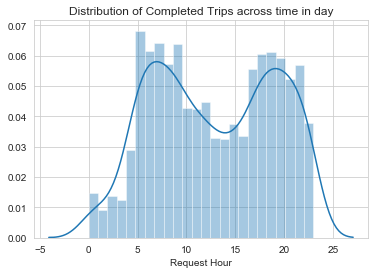

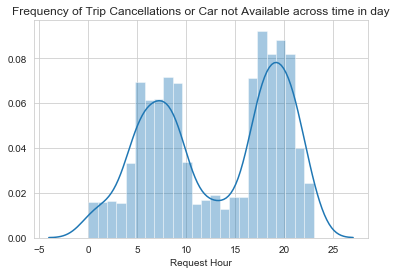

In [10]:
# Let's try to analyse when the Trips get completed
df_requests_completed = uber_df.loc[uber_df['Status'] =='Trip Completed']
fig = sns.distplot(df_requests_completed['Request Hour'],bins=24)
fig.set_title('Distribution of Completed Trips across time in day')
plt.show()
# From the graph it looks like the most number of Trips are being completed
# either at Morning Hours or  Evening Hours

# Now let's analyse when are Cars not available or there are trip cancellations
df_cancelled_or_car_not_available = uber_df.loc[(uber_df['Status'] =='Cancelled')\
                                         | (uber_df['Status'] =='No Cars Available') ]
fig = sns.distplot(df_cancelled_or_car_not_available['Request Hour'],bins=24)
fig.set_title('Frequency of Trip Cancellations or Car not Available across time in day')
plt.show()
# From the graph ot looks like 5am -10 am and 5pm- 10 pm are more problematic
# i.e. Morning Hours and Evenings Hours are problematic




/Users/karandeepmalik/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


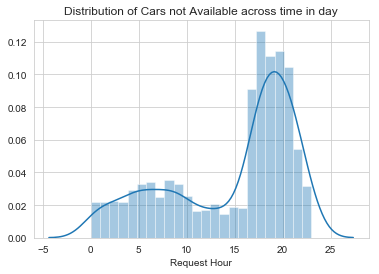

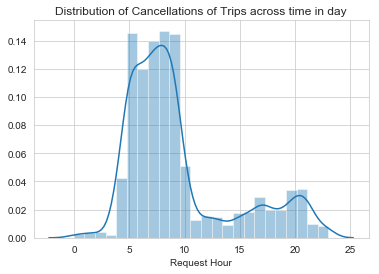

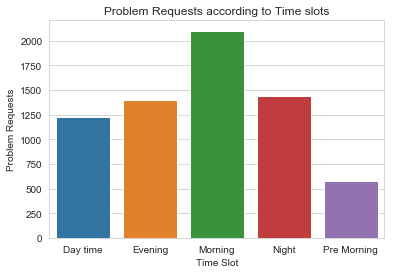

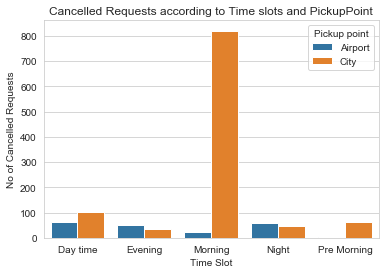

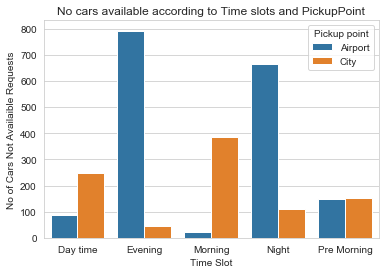

In [11]:
# Creation of Derived Metrics
# Since we see that the problem happens in certain time intervals let's create 
# a derived metrics for time slots 
# Pre Morning, Morning ,Day Time,Evening , Night
# The time slost are crated as follows
# 1) 12 am - 5 am - Pre Morning
# 2) 5 am - 10 am - Morning
# 3) 10 am - 5 pm - Day Time
# 4) 5 pm - 8 pm - Evening
# 5) 8 pm - 12 am - Night
uber_df['Time Slot'] = uber_df['Request Hour'].apply(lambda x: \
                                                     'Pre Morning'if x< 5 \
                                                      else ('Morning' if x < 10 \
                                                      else ('Day time' if x < 17 \
                                                      else ( 'Evening' if x<20 \
                                                      else 'Night'))))

# Let's analyse specifically  when cars are not available 
df_requests_cars_not_avail = uber_df.loc[uber_df['Status'] =='No Cars Available']
fig = sns.distplot(df_requests_cars_not_avail['Request Hour'],bins=24)
fig.set_title('Distribution of Cars not Available across time in day')
plt.show()
# From the graph it looks like the peak when cars not available during 5pm to 10 pm
# So Evening Hours is problematic

# Let's also analyse when trips get cancelled
df_requests_cancelled = uber_df.loc[uber_df['Status'] =='Cancelled' ]
fig = sns.distplot(df_requests_cancelled['Request Hour'],bins=24)
fig.set_title('Distribution of Cancellations of Trips across time in day')
plt.show()
# From the graph it looks like the peak of trips  getting cancelled is during 
# 5 am - 10 am . So, Morning Hours is problematic


# Analysing Problem requests by Time slot
uber_df_problem_requests_by_time_slot =  uber_df.groupby(by=['Time Slot'])['Time Slot'].count()\
                                          .reset_index(name='Problem Requests')
fig = sns.barplot(x='Time Slot', y='Problem Requests', data=uber_df_problem_requests_by_time_slot)
fig.set_title('Problem Requests according to Time slots')
plt.show()
# The most problematic time slot is Morning 


# Analysing 'Cancelled' requests by Pickup point
uber_df_cancel_by_time_slot_pickup_point = df_requests_cancelled.groupby(by=['Time Slot','Pickup point'])\
                                           ['Time Slot'].count()\
                                           .reset_index(name='No of Cancelled Requests')
fig = sns.barplot(x="Time Slot", y='No of Cancelled Requests', \
                  hue='Pickup point',data=uber_df_cancel_by_time_slot_pickup_point)
fig.set_title('Cancelled Requests according to Time slots and PickupPoint')
plt.show()

# Analysing requests with 'No Cars Available' Status by Pickup point
uber_df_no_cars_avail_by_time_slot_pickup_point = \
                    df_requests_cars_not_avail.groupby(by=['Time Slot','Pickup point'])\
                   ['Time Slot'].count() \
                  .reset_index(name='No of Cars Not Availaible Requests')
fig = sns.barplot(x="Time Slot", y='No of Cars Not Availaible Requests', \
                  hue='Pickup point', \
                  data=uber_df_no_cars_avail_by_time_slot_pickup_point)
fig.set_title('No cars available according to Time slots and PickupPoint')
plt.show()



/Users/karandeepmalik/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


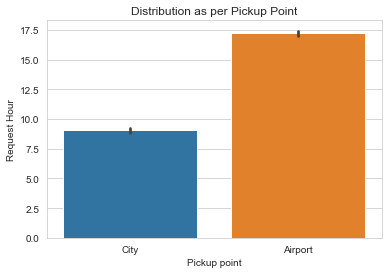

In [12]:
# Let's analyse trips on the basis of pick up point
fig = sns.barplot(x="Pickup point", y='Request Hour', \
                  data=df_cancelled_or_car_not_available)
fig.set_title('Distribution as per Pickup Point')
plt.show()
# From the graph we can see that, Airport to City Trips are more Problematic


Driver id
1.0        13.0
2.0        26.0
3.0        42.0
4.0        60.0
5.0        65.0
6.0        84.0
7.0        77.0
8.0        72.0
9.0       171.0
10.0      100.0
11.0       88.0
12.0      144.0
13.0      195.0
14.0      168.0
15.0      150.0
16.0      304.0
17.0      255.0
18.0      216.0
19.0      228.0
20.0      320.0
21.0      210.0
22.0      462.0
23.0      345.0
24.0      480.0
25.0      350.0
26.0      260.0
27.0      594.0
28.0      392.0
29.0      377.0
30.0      480.0
          ...  
271.0    2981.0
272.0    3536.0
273.0    3549.0
274.0    4932.0
275.0    4125.0
276.0    4416.0
277.0    3878.0
278.0    3336.0
279.0    4743.0
280.0    3920.0
281.0    3653.0
282.0    3102.0
283.0    3679.0
284.0    4828.0
285.0    3705.0
286.0    4576.0
287.0    3731.0
288.0    2592.0
289.0    4046.0
290.0    4350.0
291.0    3492.0
292.0    2336.0
293.0    2344.0
294.0    4116.0
295.0    3540.0
296.0    4144.0
297.0    4455.0
298.0    4470.0
299.0    3588.0
300.0    1800.0
Name: Driver i

/Users/karandeepmalik/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


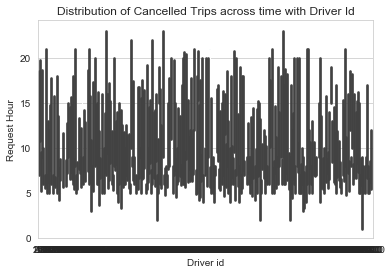

In [13]:

# Now checking if there is any particular Driver Ids when Trip is getting Cancelled
print( uber_df.groupby(by=['Driver id'])['Driver id'].sum())
# Observation :- Total 300 driver ids. Since Length (see below) and Driver Ids
# both range from 1 to 300 it is safe to say there are 300 drivers Ids and we 
# have data for all of them

fig = sns.barplot(x='Driver id',y='Request Hour',data=df_requests_cancelled)
fig.set_title('Distribution of Cancelled Trips across time with Driver Id')
plt.show()

# From the graph it looks like there is no big outlier i.e everyone is having cancelled 
# rides with some variation.



    Request Day    Time Slot  Demand  Supply  Gap
0            11     Day time     256     167   89
1            11      Evening     285     103  182
2            11      Morning     437     180  257
3            11        Night     285     114  171
4            11  Pre Morning     104      37   67
5            12     Day time     253     152  101
6            12      Evening     281      87  194
7            12      Morning     404     180  224
8            12        Night     270     103  167
9            12  Pre Morning      99      40   59
10           13     Day time     227     140   87
11           13      Evening     264      97  167
12           13      Morning     420     176  244
13           13        Night     298     117  181
14           13  Pre Morning     128      47   81
15           14     Day time     221     132   89
16           14      Evening     306     103  203
17           14      Morning     426     157  269
18           14        Night     270      90  180


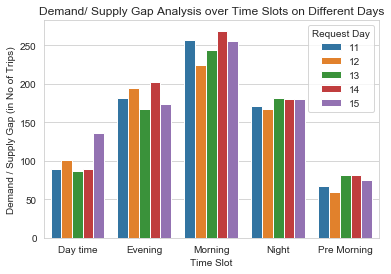

In [14]:
# Now,let's look at the Demand and Supply

# Demand is when we are getting Trips as Completed,Cancelled or No Drivers Available
# Supply is when Trips are getting completed
uber_df_demand_by_time_slot =  uber_df.groupby(by=['Request Day','Time Slot'])\
                               ['Time Slot'].count().reset_index(name='Demand')

uber_df_supply = uber_df.loc[uber_df['Status']=="Trip Completed"]
uber_df_supply_by_time_slot = uber_df_supply.groupby(by=['Request Day','Time Slot']) \
                             ['Time Slot'].count().reset_index(name='Supply')

uber_df_demand_supply = uber_df_demand_by_time_slot
uber_df_demand_supply['Supply'] = uber_df_supply_by_time_slot['Supply']


# Since the problem is regarding Demand and Supply


# Let's find the Gap i.e. Demand - Supply over various timeslots for different days

uber_df_demand_supply['Gap'] = uber_df_demand_supply['Demand'] - \
                               uber_df_demand_supply['Supply'] 

print(uber_df_demand_supply)

# Now plotting the Gap between demand and supply against Time Slots
fig = sns.barplot(x='Time Slot', y='Gap', hue='Request Day', \
                  data=uber_df_demand_supply)
fig.set(xlabel='Time Slot', ylabel='Demand / Supply Gap (in No of Trips)')
fig.set_title("Demand/ Supply Gap Analysis over Time Slots on Different Days")
plt.show()
 # The highest Gap exists during Mornings for all days

  Pickup point    Time Slot  Demand  Supply   Gap
0      Airport     Day time     478     327   151
1      Airport      Evening    1079     238   841
2      Airport      Morning     426     382    44
3      Airport        Night    1002     277   725
4      Airport  Pre Morning     253     103   150
5         City     Day time     746     395   351
6         City      Evening     322     243    79
7         City      Morning    1677     472  1205
8         City        Night     437     283   154
9         City  Pre Morning     325     111   214


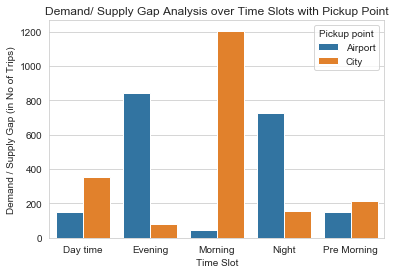

In [15]:

# Now let's analyse the types of requests (city-airport or airport-city) for which 
# the gapis the most severe in the identified time slots


# Let's figure out Demand By Pickup Point and Time Slots
uber_df_demand_by_pickup_time_slot = uber_df.groupby(by=['Pickup point','Time Slot']) \
                                     ['Time Slot'].count().reset_index(name='Demand')

# Let's figure out Supply By Pickup Point and Time Slots
uber_df_supply_by_pickup_time_slot = uber_df_supply.groupby(['Pickup point','Time Slot'])\
                                     ['Time Slot'].count().reset_index(name='Supply')


# Let's unify the above data
uber_df_demand_supply_by_pickup =  pd.concat([uber_df_demand_by_pickup_time_slot, \
                                  uber_df_supply_by_pickup_time_slot['Supply']\
                                  .to_frame()], axis=1, sort=False)

# Calculate Gap
uber_df_demand_supply_by_pickup['Gap'] = uber_df_demand_supply_by_pickup['Demand'] \
                                         - uber_df_demand_supply_by_pickup['Supply'] 

print(uber_df_demand_supply_by_pickup)

# Plotting Gap against Time Slots
fig = sns.barplot(x='Time Slot', y='Gap', hue='Pickup point', \
                    data=uber_df_demand_supply_by_pickup)
fig.set(xlabel='Time Slot', ylabel='Demand / Supply Gap (in No of Trips)')
fig.set_title("Demand/ Supply Gap Analysis over Time Slots with Pickup Point")
plt.show()

# During Morning Rush we have biggest Gap between City to Airport.
# During Evening and Night we have bigger problem from Aiport to City
# During Day time and Pre-Morning the Gap is not that wide but still considerable 
# from City to Airport 


# It can be  seen from graph that in the Pre-morning there are  no cancelled 
# requests from airport and there is Demand as well. The Demand could be from 
# international flights coming in airport and drivers were not cancelling requests.
# This could be attributed to the fact that drivers were waiting at the airport 
# overnight and rode customers from International Flights to City from Airport. 
# Drivers would prefer wiating at airport because there is very less demand in 
# City during early morning and drivers have already spent a lot of fuel in getting 
# to airport at night, they prefer to stay near/at airport for early morning flights.

# Also, im the morning there are very few instances of Cars not Available at airport.
# So all cars that came in early morning to drop International passengers from City 
# to Airport and all cars that came during morning to drop domestic passengers from 
# City to Airport were actually meeting the requests from Airport. So, Gap at 
# the airport is minimal during morning. Also, there are very few cancellations early
# morning from City because there are very few travellers in the city in early morning,
# so if drivers get a ride from City to Airport they mostly accept it.  

# It can also be seen that in the morning there are high no of cancellations from City
# to Airport. Since airport trips take a lot of time to complete and drivers usually
# have to stay at airport till they get a passenger back from Airport to City and 
# there are alternate intra city rides (rides within city) available during the day,
# the drivers prefer intra city rides and cancel City to Airport Rides.

# During evenings and night there is a problem of cars not being available at the
# airport to fulfill demand this is because there is a surge in domestic travellers
# during evenings and nights due to domestic flights at airport and there are not
# many cars staying over in day time (as they get alternatively lot of intracity 
# rides during day time).
